# IV Smiles in the Lifted Heston model

In [2]:
# Import necessary libraries
import numpy as np
import math
from py_vollib_vectorized import vectorized_implied_volatility as iv
import matplotlib.pyplot as plt

- **Weights \( c_i \):**
  $$
  c_i = \frac{(r^{1 - \alpha} - 1) \cdot r^{(1 - \alpha)(i - 1 - \frac{n}{2})}}{\Gamma(\alpha) \, \Gamma(2 - \alpha)}
  $$

- **Mean reversion rates \( x_i \):**
  $$
  x_i = \frac{(1 - \alpha)(r^{2 - \alpha} - 1) \cdot r^{i - 1 - \frac{n}{2}}}{(2 - \alpha)(r^{1 - \alpha} - 1)}
  $$

- **Function \( F(u, v) \):**
  $$
  F(u, v) = \frac{1}{2}(u^2 - u) + (\rho \nu u - \lambda)v + \frac{1}{2} \nu^2 v^2
  $$

- **Initial forward variance curve \( g_0(t) \):**
  $$
    g_0(t) = V_0 + \lambda \theta \sum_{i=1}^{n} c_i \int_0^t e^{-x_i s} \, ds
    $$

In [4]:
def compute_c(r, n, alpha):
    c = np.array([(r**(1 - alpha) - 1) * (r**((1 - alpha) * (ii - 1 - n / 2))) / (math.gamma(alpha) * math.gamma(2 - alpha)) for ii in range(1, n + 1)])
    return c

def compute_x(r, n, alpha):
    x = np.array([(1 - alpha) * (r**(2 - alpha) - 1) * (r**(ii - 1 - n / 2)) / ((2 - alpha) * (r**(1 - alpha) - 1)) for ii in range(1, n + 1)])
    return x

def F(u, v, rho, nu, lamb):
    return 0.5 * (u**2 - u) + (rho * nu * u - lamb) * v + 0.5 * (nu**2) * (v**2)

def g0(t, x, c, V0, lamb, theta):
    integral = (1 - np.exp(-x * t)) / x # explicit formula for the integral contained in the second term of of g0(t)
    return V0 + lamb * theta * c @ integral

## Question 3

$$
\psi_{t_{k+1}}^i \approx \frac{1}{1 + x_i \Delta t} \left( \psi_{t_k}^i + F\left( u, \sum_{j=1}^n c_j \psi_{t_k}^j \right) \Delta t \right)
$$

$$
\phi(t, T) = \int_0^{T - t} F\left( u, \sum_{j=1}^n c_j \psi^j(s) \right) g_0(T - s) \, \mathrm{d}s
$$

In [7]:
def Ch_Lifted_Heston(u, S0, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, grid):
    delta_t = T / M # time discretization step
    # Initialize space for the variables needed
    psi = np.zeros((n, grid), dtype = complex)
    F_vector = np.zeros((M + 1, grid), dtype = complex)
    g0_vector = np.zeros(M + 1, dtype = complex)

    c, x = compute_c(rn, n, alpha), compute_x(rn, n, alpha) # compute weights and mean reversion rates
    x = x.reshape(n, 1)

    # Iterate through time to find the values needed to compute phi
    for ii in range(M):
        F_vector[ii, :] = F(u, c @ psi, rho, nu, lamb)
        psi = (1 / (1 + x * delta_t)) * (psi + F_vector[ii, :] * delta_t)
        g0_vector[ii] = g0((M - ii) * delta_t, x, c, V0, lamb, theta)[0]
    F_vector[-1, :], g0_vector[-1] = F(u, c @ psi, rho, nu, lamb), g0(0, x, c, V0, lamb, theta)[0]

    g0_vector = g0_vector.reshape(M + 1, 1)
    # Trapezoidal  rule to approximate the integral required by the computation of phi
    phi = np.exp(u * np.log(S0) + np.sum(((F_vector[1:, :] * g0_vector[1:] + F_vector[:-1, :] * g0_vector[:-1]) * delta_t) / 2, axis = 0))
    return phi

## Question 4

$$
C_0 = \frac{e^{-rT - \alpha^2 \log(K)}}{\pi} \int_0^\infty \text{Re} \left( \frac{\Phi_T(u - i(\alpha^2 + 1)) \, e^{-iu \log(K)}}{(\alpha^2 + iu)(\alpha^2 + 1 + iu)} \right) \, \mathrm{d}u
$$

In [10]:
def Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, alpha2, L, grid = 10000):
    def integrand(u):
        # Integrand function
        phi_T = Ch_Lifted_Heston(1j * (u - (alpha2 + 1) * 1j), S0, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, grid)
        denominator = (alpha2 + 1j * u) * (alpha2 + 1 + 1j * u)
        exponential_term = np.exp(-1j * np.log(K) * u)
        
        return np.real((phi_T / denominator) * exponential_term)

    def compute_integral(L):
        # Trapezoidal rule to approximate the integral
        delta = L / grid
        points = np.arange(0, L, delta)
        function = integrand(points)
        result = np.sum(((function[:, 1:] + function[:, :-1]) * delta) / 2, axis = 1).reshape(-1, 1)

        return result

    integral = compute_integral(L)
    C0_value = (np.exp(-alpha2 * np.log(K)) / np.pi) * integral
    return C0_value

## Question 5

In [12]:
# Parameters for the implied volatilities
S0, rho, lamb, theta, nu, V0, alpha, alpha2, M = 1, -0.7, 0.3, 0.02, 0.3, 0.02, 0.6, 1, 100
n_values = [5, 10, 20, 50]

In [13]:
# Compute IV
T, L, log_K = 1, 100, np.linspace(-1.2, 0.2, 20)
K = np.exp(log_K.reshape(20, 1))
implied_volatilities_list = []

for n in n_values:
    rn = 1 + 10 * (n**(-0.9))
    implied_volatilities = []
    call_price_lifted_heston = Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, alpha2, L).reshape(1, -1)
    implied_volatilities.append(iv(call_price_lifted_heston, S0, np.exp(log_K), T, 0, 'c', return_as='numpy'))
    implied_volatilities_list.append(implied_volatilities)

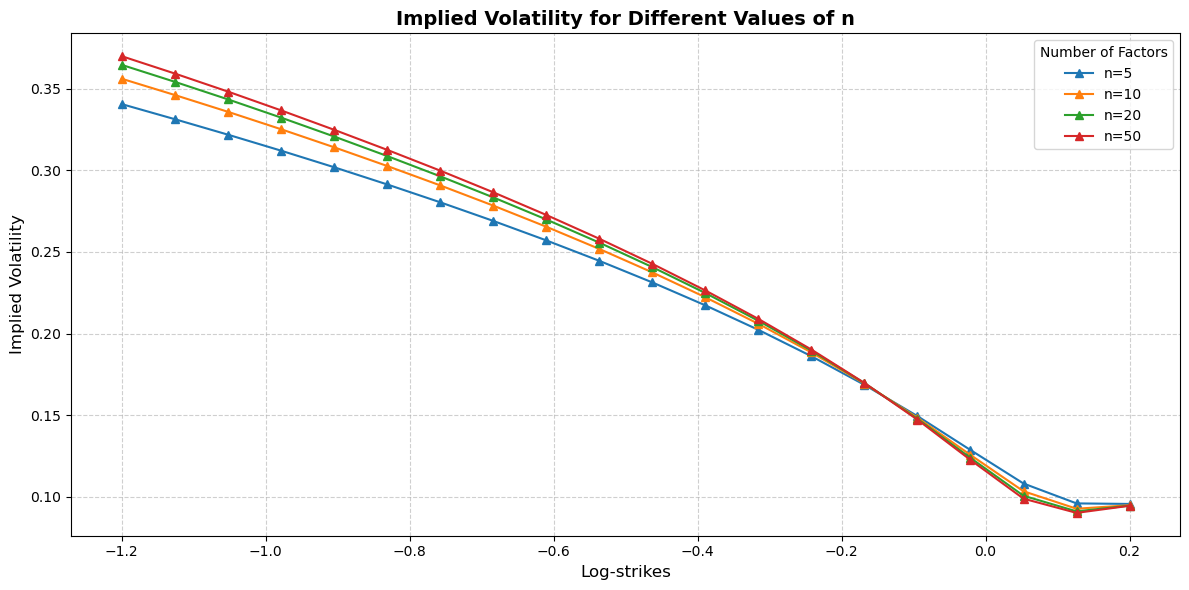

In [14]:
plt.figure(figsize=(12, 6))

for idx, n in enumerate(n_values):
    plt.plot(log_K, implied_volatilities_list[idx][0], marker='^', linestyle='-', label=f"n={n}")

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Log-strikes", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.title("Implied Volatility for Different Values of n", fontsize=14, fontweight='bold')
plt.legend(title="Number of Factors", fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()

In [15]:
# Compute IV
T, L, log_K = 1/26, 1000, np.linspace(-0.15, 0.05, 20)
K = np.exp(log_K.reshape(20, 1))
implied_volatilities_list = []

for n in n_values:
    rn = 1 + 10 * (n**(-0.9))
    implied_volatilities = []
    call_price_lifted_heston = Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, rn, alpha, M, alpha2, L).reshape(1, -1)
    implied_volatilities.append(iv(call_price_lifted_heston, S0, np.exp(log_K), T, 0, 'c', return_as='numpy'))
    implied_volatilities_list.append(implied_volatilities)

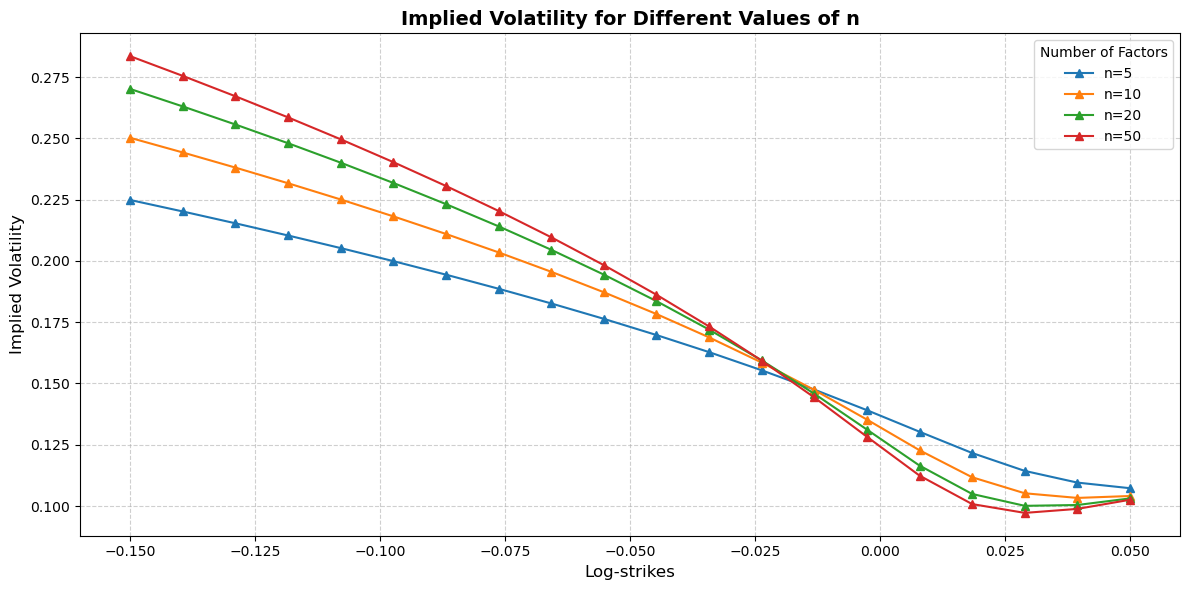

In [16]:
plt.figure(figsize=(12, 6))

for idx, n in enumerate(n_values):
    plt.plot(log_K, implied_volatilities_list[idx][0], marker='^', linestyle='-', label=f"n={n}")

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Log-strikes", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.title("Implied Volatility for Different Values of n", fontsize=14, fontweight='bold')
plt.legend(title="Number of Factors", fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()